In [1]:
library(Matching)
library(plyr)
library(tidyverse)
library(stringr)
library(magrittr)
library(caret)
library(itecv)

Warning message:
: package ‘Matching’ was built under R version 3.2.3Loading required package: MASS
## 
##  Matching (Version 4.9-2, Build Date: 2015-12-25)
##  See http://sekhon.berkeley.edu/matching for additional documentation.
##  Please cite software as:
##   Jasjeet S. Sekhon. 2011. ``Multivariate and Propensity Score Matching
##   Software with Automated Balance Optimization: The Matching package for R.''
##   Journal of Statistical Software, 42(7): 1-52. 
##

Warning message:
: package ‘plyr’ was built under R version 3.2.5Warning message:
: package ‘tidyverse’ was built under R version 3.2.5Warning message:
: replacing previous import by ‘tidyr::%>%’ when loading ‘broom’Warning message:
: replacing previous import by ‘tidyr::gather’ when loading ‘broom’Warning message:
: replacing previous import by ‘tidyr::spread’ when loading ‘broom’Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyvers

In [6]:
models = list(
# ranger_spec = list(method = "ranger",
#                    tune_grid = expand.grid(mtry = c(3,5),
#                                            splitrule="variance",
#                                            min.node.size=5)),
gbm_spec = list(method = "gbm",
                tune_grid = expand.grid(n.trees = seq(1,501,50), 
                                        interaction.depth=3, 
                                        shrinkage = 0.2, 
                                        n.minobsinnode=3)),
enet_spec = list(method = "enet",
                 tune_grid = expand.grid(fraction=0.5,
                                         lambda=exp(seq(-5,2,0.5))))
# nnet_spec = list(method = "nnet",
#                  tune_grid = expand.grid(size = seq(10,30,5),
#                                          decay = exp(seq(-7,0,1))))
)

DGP = powers_DGPs()[[7]]
n_folds = 5
rep = 1
n_train = 500
n_test = 1000

data_stuff = setup_data(DGP, n_train, n_test, n_folds)
estimate_stuff = data_stuff %$% get_estimates(data, models, cv_index, test_index)
# estimate_stuff = data_stuff %$% get_estimates(data, list(models[[2]]), cv_index, test_index)
error_stuff = estimate_stuff %$% get_errors(cv_estimates, test_estimates, data_stuff$aux_data)

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1       20.7499             nan     0.2000    1.9968
     2       19.3152             nan     0.2000    0.0324
     3       18.1306             nan     0.2000    0.5769
     4       17.4908             nan     0.2000    0.6295
     5       16.7361             nan     0.2000   -0.1235
     6       16.3999             nan     0.2000   -0.3328
     7       16.0250             nan     0.2000   -0.3747
     8       15.5967             nan     0.2000   -0.1825
     9       14.9669             nan     0.2000   -0.4112
    10       14.8463             nan     0.2000   -0.7546
    20       12.1428             nan     0.2000   -0.3242
    40        8.3853             nan     0.2000   -0.1023
    60        6.5598             nan     0.2000   -0.3270
    80        5.1113             nan     0.2000   -0.0766
   100        3.8863             nan     0.2000   -0.0943
   120        3.1377             nan     0.2000   -0.2189
   140        

Warning message:
In bind_rows_(x, .id): binding character and factor vector, coercing into character vectorWarning message:
In bind_rows_(x, .id): binding character and factor vector, coercing into character vector

## plot

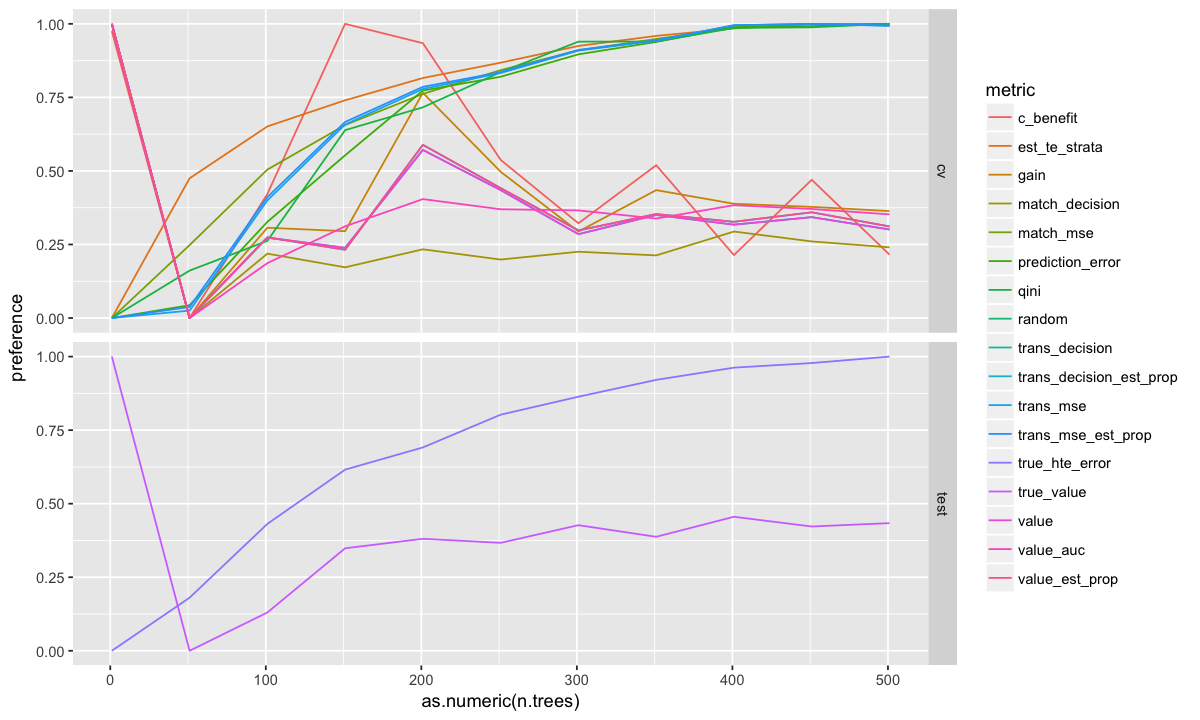

In [7]:
options(repr.plot.width=10, repr.plot.height=6)

cv_plot = error_stuff$cv_error %>%
#     filter(selection_method %in% c("gain", "qini", "value", "value_auc")) %>%
    filter(str_detect(model,"^gbm")) %>%
    separate(model, c("method", names(models[[1]]$tune_grid)), sep="~") %>%
    rename(metric=selection_method) %>%
    group_by(metric) %>%
    mutate(preference = (error - min(error, na.rm=T))/(max(error, na.rm=T)-min(error, na.rm=T))) %>%
    mutate(evaluation = "cv") 

# ggplot(aes(x=as.numeric(nrounds), y=preference)) + 
#     geom_line(aes(color=metric)) 

test_plot = error_stuff$test_error %>% 
    filter(str_detect(model,"^gbm")) %>%
    separate(model, c("method", names(models[[1]]$tune_grid)), sep="~") %>%
    gather(metric, error, true_hte_error, true_value) %>%
    group_by(metric) %>%
    mutate(preference = (error - min(error))/(max(error)-min(error))) %>%
    mutate(evaluation = "test")

# # ggplot(aes(x=as.numeric(nrounds), y=preference)) + 
# #     geom_line(aes(color=metric), size=3) 

cv_plot %>% bind_rows(test_plot) %>%
ggplot(aes(x=as.numeric(n.trees), y=preference)) + 
    geom_line(aes(color=metric)) + 
    facet_grid(evaluation~.)

In [11]:
error_stuff$true_selection_error %>% arrange(-true_hte_error) %>% data.frame

,model,selection_method,true_hte_error,true_value
1,nnet~30~0.367879441171442,match_decision,4.694407,-1.071375
2,nnet~25~0.135335283236613,gain,4.693598,-0.991706
3,nnet~25~0.135335283236613,trans_decision,4.693598,-0.991706
4,nnet~25~0.135335283236613,value,4.693598,-0.991706
5,nnet~20~1,oracle_selector_true_value,4.686207,-1.071798
6,nnet~30~1,random,4.686001,-1.071188
7,nnet~30~0.00247875217666636,c_benefit,4.6403,-0.7019732
8,ranger~5~variance~5,est_te_strata,1.392353,-0.9842382
9,ranger~5~variance~5,match_mse,1.392353,-0.9842382
10,ranger~5~variance~5,prediction_error,1.392353,-0.9842382


In [55]:
processed_results = results %>%
    group_by(DGP, rep) %>% 
    mutate(rel_value = true_value/max(true_value, rm.na=T),
#        rel_value_opt = true_deficiency/optimal_deficiency,
       rel_increased_error = true_hte_error/min(true_hte_error, rm.na=T))

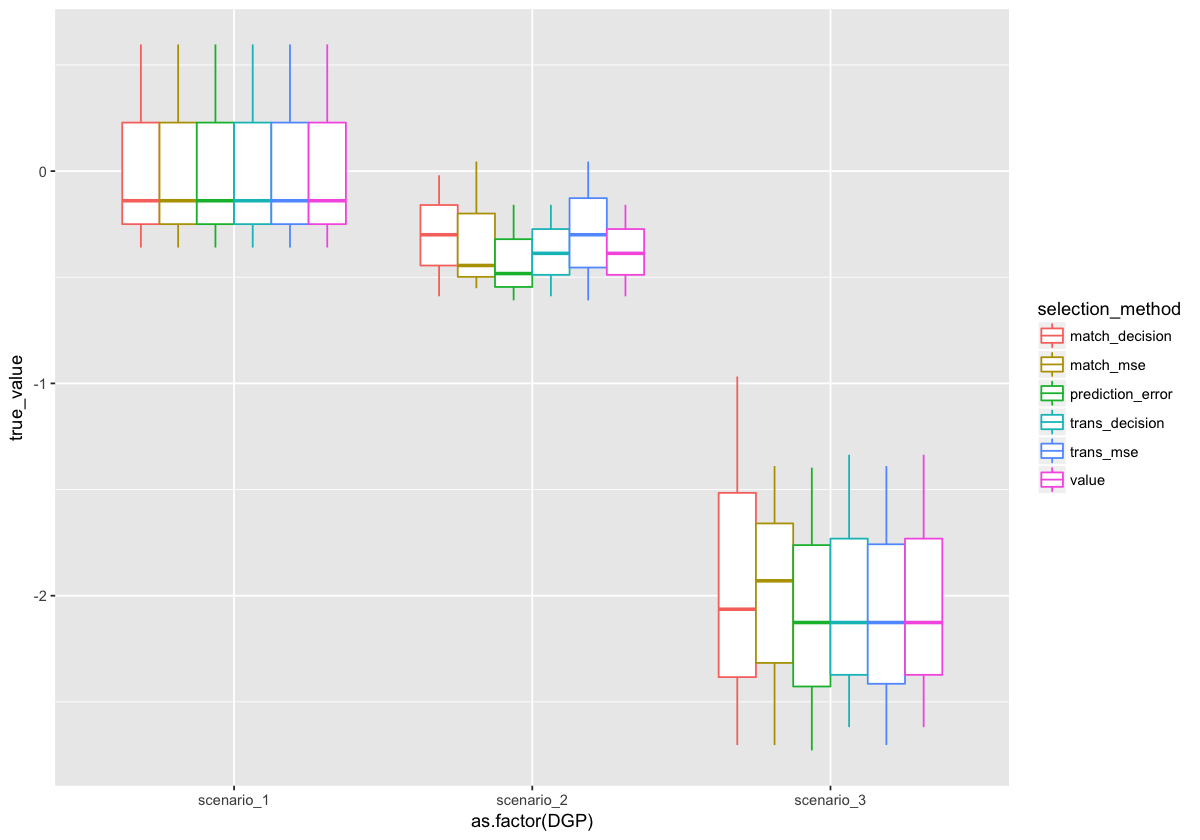

In [57]:
options(repr.plot.width=10, repr.plot.height=7)
processed_results %>%
ggplot(aes(x=as.factor(DGP), y=true_value, color=selection_method)) +
    geom_boxplot()

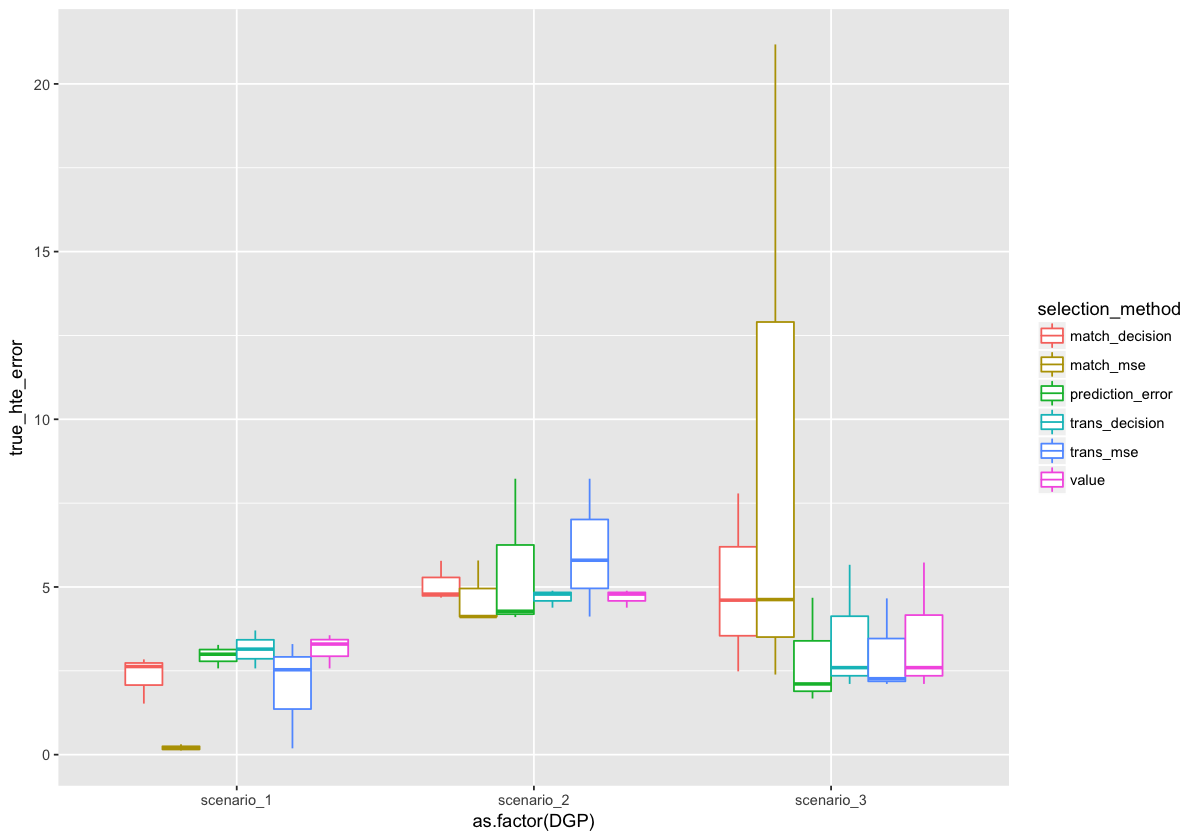

In [58]:
options(repr.plot.width=10, repr.plot.height=7)
results %>%
ggplot(aes(x=as.factor(DGP), y=true_hte_error, color=selection_method)) +
    geom_boxplot()